In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [67]:
df = pd.read_csv('../dataset/GOOG.csv')
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2006-01-03,217.021545,208.329132,210.471100,216.802368,26340763.0,216.802368
1,2006-01-04,223.641739,219.053925,221.121185,221.788681,30687394.0,221.788681
2,2006-01-05,224.931900,219.925659,222.167267,224.777481,21697624.0,224.777481
3,2006-01-06,234.371521,225.773743,227.581970,231.960556,35646914.0,231.960556
4,2006-01-09,235.816101,229.609375,232.334152,232.578247,25679694.0,232.578247


In [68]:
short_window = 7 #int(0.025 * len(df))
long_window = 30 #int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# hold if current market is hot 
# sell if market is cold
signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()
# let's buy the first day, sell last day
signals.positions[0]=1
signals.positions.iloc[-1]= -1
signals

,signal,short_ma,long_ma,positions
0,0.0,216.802368,216.802368,1.0
1,0.0,219.295525,219.295525,0.0
2,0.0,221.122843,221.122843,0.0
3,0.0,223.832272,223.832272,0.0
4,0.0,225.581467,225.581467,0.0
...,...,...,...,...
3771,0.0,1739.430001,1770.809668,0.0
3772,0.0,1741.299997,1771.684668,0.0
3773,0.0,1742.845703,1771.074666,0.0
3774,0.0,1744.061419,1769.679333,0.0


<AxesSubplot:>

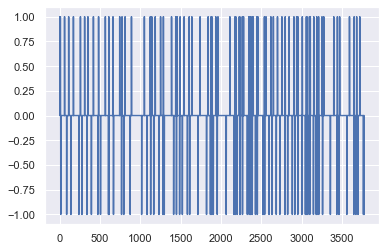

In [69]:
signals.positions.plot()

In [70]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1000,
    max_sell = 1000,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, -1 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] ):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [71]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['positions'])

day 0: buy 46 units at price 9972.908936, total balance 27.091064
day 7: total balances 27.091064, not enough money to buy a unit price 230.949341
day 12, sell 46 units at price 9153.271423, investment -13.840775 %, total balance 9180.362488,
day 59: buy 46 units at price 9050.615814, total balance 129.746674
day 85, sell 46 units at price 9035.034241, investment -0.172160 %, total balance 9164.780914,
day 110: buy 48 units at price 9122.765625, total balance 42.015289
day 138, sell 48 units at price 9327.677490, investment 2.246159 %, total balance 9369.692780,
day 169: buy 48 units at price 9190.193115, total balance 179.499664
day 237, sell 48 units at price 11570.949463, investment 25.905401 %, total balance 11750.449127,
day 256: buy 48 units at price 11703.173584, total balance 47.275543
day 275, sell 48 units at price 11238.116455, investment -3.973769 %, total balance 11285.391998,
day 308: buy 48 units at price 11085.329590, total balance 200.062408
day 337, sell 48 units at p

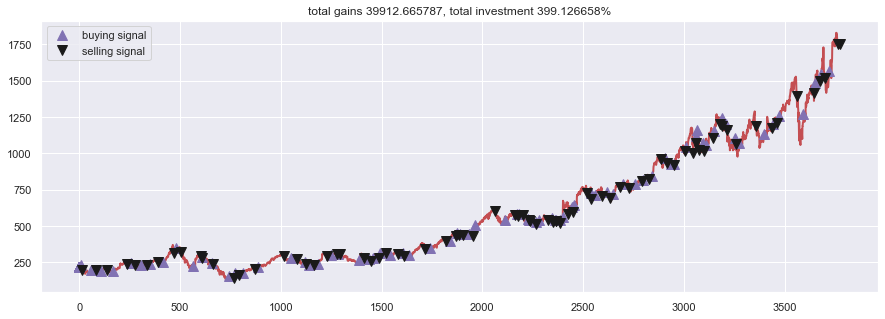

In [72]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()